# Mod 4 Project - Starter Notebook

This notebook has been provided to you so that you can make use of the following starter code to help with the trickier parts of preprocessing the Zillow dataset. 

The notebook contains a rough outline the general order you'll likely want to take in this project. You'll notice that most of the areas are left blank. This is so that it's more obvious exactly when you should make use of the starter code provided for preprocessing. 

**_NOTE:_** The number of empty cells are not meant to infer how much or how little code should be involved in any given step--we've just provided a few for your convenience. Add, delete, and change things around in this notebook as needed!

# Some Notes Before Starting

This project will be one of the more challenging projects you complete in this program. This is because working with Time Series data is a bit different than working with regular datasets. In order to make this a bit less frustrating and help you understand what you need to do (and when you need to do it), we'll quickly review the dataset formats that you'll encounter in this project. 

## Wide Format vs Long Format

If you take a look at the format of the data in `zillow_data.csv`, you'll notice that the actual Time Series values are stored as separate columns. Here's a sample: 

<img src='https://raw.githubusercontent.com/learn-co-students/dsc-mod-4-project-seattle-ds-102819/master/images/df_head.png'>

You'll notice that the first seven columns look like any other dataset you're used to working with. However, column 8 refers to the median housing sales values for April 1996, column 9 for May 1996, and so on. This This is called **_Wide Format_**, and it makes the dataframe intuitive and easy to read. However, there are problems with this format when it comes to actually learning from the data, because the data only makes sense if you know the name of the column that the data can be found it. Since column names are metadata, our algorithms will miss out on what dates each value is for. This means that before we pass this data to our ARIMA model, we'll need to reshape our dataset to **_Long Format_**. Reshaped into long format, the dataframe above would now look like:

<img src='https://raw.githubusercontent.com/learn-co-students/dsc-mod-4-project-seattle-ds-102819/master/images/melted1.png'>

There are now many more rows in this dataset--one for each unique time and zipcode combination in the data! Once our dataset is in this format, we'll be able to train an ARIMA model on it. The method used to convert from Wide to Long is `pd.melt()`, and it is common to refer to our dataset as 'melted' after the transition to denote that it is in long format. 

# Helper Functions Provided

Melting a dataset can be tricky if you've never done it before, so you'll see that we have provided a sample function, `melt_data()`, to help you with this step below. Also provided is:

* `get_datetimes()`, a function to deal with converting the column values for datetimes as a pandas series of datetime objects
* Some good parameters for matplotlib to help make your visualizations more readable. 

Good luck!


# Step 1: Load the Data/Filtering for Chosen Zipcodes

In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('zillow_data.csv')

In [3]:
#Make sure data was imported correctly

df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


# Step 2: Data Preprocessing

In [4]:
#Helpter function to pivot from wide to long format

def melt_data(df):
    melted = pd.melt(df, id_vars=['RegionName', 'City', 'State', 'Metro', 'CountyName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted#melted.groupby('time').aggregate({'value':'mean'})

In [5]:
# Drop columns that aren't included in the helper function

df.drop(columns=['RegionID','SizeRank'], axis=1, inplace=True)

In [6]:
# Ensure data is melted

df_melted = melt_data(df)
df_melted.head(5)

,RegionName,City,State,Metro,CountyName,time,value
0,60657,Chicago,IL,Chicago,Cook,1996-04-01,334200.0
1,75070,McKinney,TX,Dallas-Fort Worth,Collin,1996-04-01,235700.0
2,77494,Katy,TX,Houston,Harris,1996-04-01,210400.0
3,60614,Chicago,IL,Chicago,Cook,1996-04-01,498100.0
4,79936,El Paso,TX,El Paso,El Paso,1996-04-01,77300.0


In [7]:
# Set DataFrame to only show Texas values

df_texas = df_melted[df_melted['State']=='TX']

In [8]:
# Set index

df_texas.set_index('time', inplace=True)

In [9]:
# Set index as datetime object

df_texas.index = pd.to_datetime(df_texas.index)

# EDA and Visualization

## 2008 Housing Bubble Recovery Time

Look into correlation of results between two different bust cycles as % change values

In [10]:
def df_maker(df, county):
    """
    Takes a DataFrame and returns sliced version only including specified county
    Parameters:
    DataFrame, country
    Returns:
    DataFrame sliced to only include specified county
    """
    df = df_texas[df_texas['CountyName']==county].copy()
    return df

In [11]:
def county_dict_maker(df):
    """
    Takes a DataFrame and returns a dictionary where keys are zip codes and values
    are DataFrames with specified zip codes and median home values
    Parameters:
    DataFrame
    Returns:
    Dictionary with zip code keys and DataFrame values
    """
    df.drop(columns=['City', 'State', 'Metro', 'CountyName'], axis=1, inplace=True)
    zips=list(df['RegionName'].unique())
    dict_full = {}
    for zip_ in zips:
        dict_full[zip_] = df[df['RegionName']==zip_]
    return dict_full

In [12]:
# Try except because certain zip codes do not full into time constra
def housing_bust_finder(df, dict_full):
    """
    Takes a DataFrame and dictionary and returns a DataFrame where each zipcode specifies
    the number of days it took to reach the max price between 2005 and 2008 along with a dictionary
    showing the frequency of number of days to reach previous maximum value
    Parameters:
    DataFrame and dictionary
    Returns:
    DataFrame where each zipcode specifies the number of days until recovery and dictionary where
    keys are frequency and values are days until recovery
    """
    # Create list of unique zip codes in the region
    zips=list(df['RegionName'].unique())
    
    # Create dictionary where keys is zip code and value is days until recovery
    # Use try/except because certain zip codes will not correspond with necessary time frame
    recover_housing_dict = {}
    for zip_ in zips:
        for zip_, vals in dict_full.items():
            try:
                idx_max_pre = dict_full[zip_]['2005-01-01':'2008-12-31']['value'].idxmax()
                val_max_pre = dict_full[zip_]['2005-01-01':'2008-12-31']['value'].max()
                idx_max_post=(dict_full[zip_]['2008-12-30':]['value']>=val_max_pre).idxmax()
                td = idx_max_post - idx_max_pre
                days = td.days
                recover_housing_dict[zip_]=days
            except ValueError:
                pass
    
    # Create dictionary where key is number of days until recovery and value is frequency
    recover_housing_counts={}
    for k, v in recover_housing_dict.items():
        if v in recover_housing_counts.keys():
            recover_housing_counts[v] +=1
        else:
            recover_housing_counts[v] = 1
    
    # Swap keys and values and return the above dictionary in the form of a Pandas series
    housing_recover=pd.Series(recover_housing_counts)
    housing_recover=pd.Series(housing_recover.index.values, index=housing_recover)
    df_housing_recover=pd.DataFrame(housing_recover)
    df_housing_recover.rename(columns={0:'Days_Until_Recovery'}, inplace=True)
    df_housing_recover.sort_values(by='Days_Until_Recovery', ascending=True, inplace=True)
    return df_housing_recover, recover_housing_dict

In [13]:
df_texas['CountyName'].value_counts(1).nlargest(10)

Harris        0.125698
Dallas        0.071883
Tarrant       0.061291
Bexar         0.057135
Travis        0.046747
Denton        0.024932
Collin        0.024261
El Paso       0.021004
Montgomery    0.020776
McLennan      0.015857
Name: CountyName, dtype: float64

Create Travis county data

Create Harris county data

In [14]:
# Create Harris county DataFrame
df_Harris = df_maker(df_texas, 'Harris')

# Create Harris county dictionary
Harris_dict_full = county_dict_maker(df_Harris)

# Create Harris county recovery dataframe and dictionary
df_Harris_days, dict_Harris_zips = housing_bust_finder(df_Harris,Harris_dict_full)

Create Dallas county data

In [15]:
# Create Dallas county DataFrame
df_Dallas = df_maker(df_texas, 'Dallas')

# Create Dallas county dictionary
Dallas_dict_full = county_dict_maker(df_Dallas)

# Create Dallas county recovery dataframe and dictionary
df_Dallas_days, dict_Dallas_zips = housing_bust_finder(df_Dallas,Dallas_dict_full)

In [16]:
# Create Travis county DataFrame
df_Travis = df_maker(df_texas, 'Travis')

# Create Travis county dictionary
travis_dict_full = county_dict_maker(df_Travis)

# Create Travis county recovery dataframe and dictionary
df_Travis_days, dict_Travis_zips = housing_bust_finder(df_Travis,travis_dict_full)

Create Tarrant county data

In [17]:
# Create Tarrant county DataFrame
df_Tarrant = df_maker(df_texas, 'Tarrant')

# Create Tarrant county dictionary
Tarrant_dict_full = county_dict_maker(df_Tarrant)

# Create Tarrant county recovery dataframe and dictionary
df_Tarrant_days, dict_Tarrant_zips = housing_bust_finder(df_Tarrant,Tarrant_dict_full)

Create Bexar county data

In [18]:
# Create Bexar county DataFrame
df_Bexar = df_maker(df_texas, 'Bexar')

# Create Bexar county dictionary
Bexar_dict_full = county_dict_maker(df_Bexar)

# Create Bexar county recovery dataframe and dictionary
df_Bexar_days, dict_Bexar_zips = housing_bust_finder(df_Bexar,Bexar_dict_full)

Create Denton county data

In [19]:
# Create Denton county DataFrame
df_Denton = df_maker(df_texas, 'Denton')

# Create Denton county dictionary
Denton_dict_full = county_dict_maker(df_Denton)

# Create Denton county recovery dataframe and dictionary
df_Denton_days, dict_Denton_zips = housing_bust_finder(df_Denton,Denton_dict_full)

Create Collin county data

In [20]:
# Create Collin county DataFrame
df_Collin = df_maker(df_texas, 'Collin')

# Create Collin county dictionary
Collin_dict_full = county_dict_maker(df_Collin)

# Create Collin county recovery dataframe and dictionary
df_Collin_days, dict_Collin_zips = housing_bust_finder(df_Collin,Collin_dict_full)

Create El Paso county data

In [21]:
# Create El Paso county DataFrame
df_El_Paso = df_maker(df_texas, 'El Paso')

# Create El Paso county dictionary
El_Paso_dict_full = county_dict_maker(df_El_Paso)

# Create El Paso county recovery dataframe and dictionary
df_El_Paso_days, dict_El_Paso_zips = housing_bust_finder(df_El_Paso,El_Paso_dict_full)

Create Montgomery county data

In [22]:
# Create Montgomery county DataFrame
df_Montgomery = df_maker(df_texas, 'Montgomery')

# Create Montgomery county dictionary
Montgomery_dict_full = county_dict_maker(df_Montgomery)

# Create Montgomery county recovery dataframe and dictionary
df_Montgomery_days, dict_Montgomery_zips = housing_bust_finder(df_Montgomery,Montgomery_dict_full)

Create McLennan county data

In [23]:
# Create McLennan county DataFrame
df_McLennan = df_maker(df_texas, 'McLennan')

# Create McLennan county dictionary
McLennan_dict_full = county_dict_maker(df_McLennan)

# Create McLennan county recovery dataframe and dictionary
df_McLennan_days, dict_McLennan_zips = housing_bust_finder(df_McLennan,McLennan_dict_full)

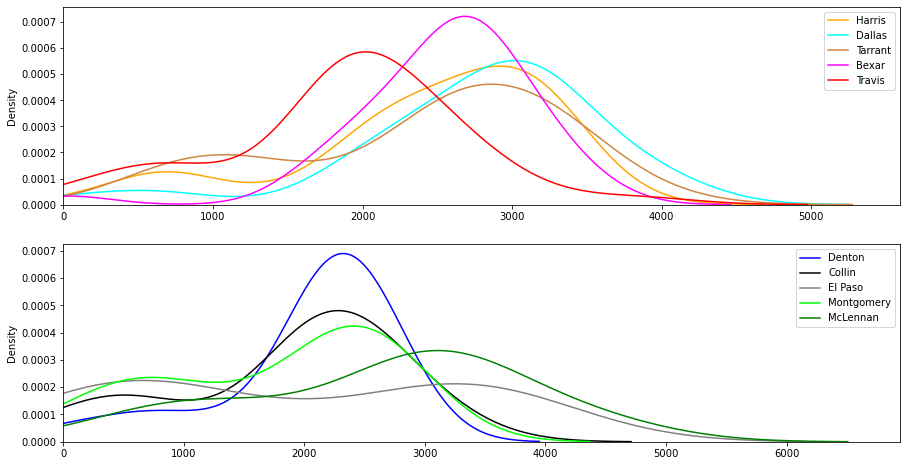

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

pair=sns.color_palette("Paired")
fig, axes = plt.subplots(figsize=(15,8), nrows=2)
sns.kdeplot(data=df_Harris_days, ax=axes[0],label='Harris', palette=['orange'])
sns.kdeplot(data=df_Dallas_days, ax=axes[0],label='Dallas', palette=['cyan'])
sns.kdeplot(data=df_Tarrant_days, ax=axes[0],label='Tarrant', palette=['peru'])
sns.kdeplot(data=df_Bexar_days, ax=axes[0],label='Bexar', palette=['magenta'])
sns.kdeplot(data=df_Travis_days, ax=axes[0],label='Travis', palette=['red'])
sns.kdeplot(data=df_Denton_days, ax=axes[1],label='Denton', palette=['blue'])
sns.kdeplot(data=df_Collin_days, ax=axes[1],label='Collin', palette=['black'])
sns.kdeplot(data=df_El_Paso_days, ax=axes[1],label='El Paso', palette=['grey'])
sns.kdeplot(data=df_Montgomery_days, ax=axes[1],label='Montgomery', palette=['lime'])
sns.kdeplot(data=df_McLennan_days, ax=axes[1],label='McLennan', palette=['green'])
axes[0].set_xlim(left=0)
axes[1].set_xlim(left=0)
axes[0].legend()
axes[1].legend();

In [25]:
big_counties_names = ['Harris','Dallas','Tarrant','Bexar','Travis']
big_counties_df = [df_Harris_days, df_Dallas_days, df_Tarrant_days, df_Bexar_days, df_Travis_days]
big_recovery_agg = {}
for name, df in zip(big_counties_names, big_counties_df):
    big_recovery_agg[name] = df['Days_Until_Recovery'].agg(['mean', 'median', 'std', 'max'])
big_county_recovery = pd.DataFrame(big_recovery_agg).T
big_county_recovery.sort_values(by=['median', 'mean', 'std', 'max'])

,mean,median,std,max
Travis,1879.512821,1947.0,790.199304,3835.0
Tarrant,2405.063830,2619.0,926.935681,3986.0
Bexar,2537.119048,2646.5,611.639189,3592.0
Harris,2432.412500,2662.5,846.344899,3622.0
Dallas,2767.155556,2953.0,835.392748,4079.0


- **Travis:** Selected due to lowest mean/median
- Tarrant: Not selected due to high standard deviation
- **Bexar:** Selected due to moderate mean/median and lowest standard deviation
- **Harris:** Selected due to superior metrics to Dallas
- Dallas: Not selected

In [26]:
small_counties_names = ['Denton','Collin','El_Paso','Montgomery','McLennan']
small_counties_df = [df_Denton_days, df_Collin_days, df_El_Paso_days, df_Montgomery_days, df_McLennan_days]
small_recovery_agg = {}
for name, df in zip(small_counties_names, small_counties_df):
    small_recovery_agg[name] = df['Days_Until_Recovery'].agg(['mean', 'median', 'std', 'max'])
small_county_recovery = pd.DataFrame(small_recovery_agg).T
small_county_recovery.sort_values(by=['median', 'mean', 'std', 'max'])

,mean,median,std,max
El_Paso,1922.615385,1704.0,1416.997032,3623.0
Collin,1867.875000,2115.5,914.517058,3134.0
Montgomery,1749.888889,2176.5,931.835563,2800.0
Denton,2031.809524,2253.0,723.378782,2769.0
McLennan,2643.866667,3011.0,1165.708238,4473.0


- **El Paso:** Selected due to lowest mean/median, however high standard deviation
- **Collin:** Selected due to low median and low standard deviation
- Montgomery: Not selected due to high standard deviation
- **Denton:** Selected due to similar median/mean as Montgomery but lower standard deviation
- McLennan: Not selected

## Top Growth Prospects
- Based on recovery time further inspecting: Travis, Bexar, Harris, El Paso, Collin, and Denton county

In [27]:
def test_county_zip_perc(df_county, county_dict_full):
    county_dict_annual = {}
    county_zips = list(county_dict_full.keys())
    for zip_ in county_zips:
        county_dict_annual[zip_] = df_county[df_county['RegionName']==zip_].resample(rule='A').mean()
        county_dict_annual[zip_]['2_Year_Pct_Change'] = county_dict_annual[zip_]['value'].pct_change(periods=2)
        county_dict_annual[zip_]['5_Year_Pct_Change'] = county_dict_annual[zip_]['value'].pct_change(periods=5)
        county_dict_annual[zip_]['10_Year_Pct_Change'] = county_dict_annual[zip_]['value'].pct_change(periods=10)
        county_dict_annual[zip_]['Std'] = county_dict_annual[zip_]['value'].std()
    
    county_comparison = {}
    county_zips = list(county_dict_annual.keys())
    for zip_ in county_zips:
        for zip_, vals in county_dict_annual.items():
            county_comparison[zip_] = county_dict_annual[zip_].iloc[-1] 
    df = pd.DataFrame(county_comparison).T
    df.drop(columns='RegionName', inplace=True)
    df['Cumulative_Score'] = df['2_Year_Pct_Change']*(0.4)+df['5_Year_Pct_Change']*(0.35)+df['10_Year_Pct_Change']*(0.25)
    df.sort_values(by='Cumulative_Score', inplace=True, ascending=False)
    return df

In [28]:
county_name_by_recovery = ['Travis', 'Bexar', 'Harris', 'El_Paso', 'Collin', 'Denton']
county_df_by_recovery = [df_Travis, df_Bexar, df_Harris, df_El_Paso, df_Collin, df_Denton]
county_dict_by_recovery = [travis_dict_full, Bexar_dict_full, Harris_dict_full, 
                           El_Paso_dict_full, Collin_dict_full, Denton_dict_full]

In [29]:
all_perc_change_dict = {}
for name, df_, dict_ in zip(county_name_by_recovery, county_df_by_recovery, county_dict_by_recovery):
    all_perc_change_dict[name] = test_county_zip_perc(df_, dict_)
all_perc_change_dict

{'Travis':           value  2_Year_Pct_Change  5_Year_Pct_Change  10_Year_Pct_Change  \
 78721  296850.0           0.217097           0.952639            1.114567   
 78758  262900.0           0.195272           0.764035            0.829188   
 78744  193825.0           0.222292           0.708713            0.654267   
 78702  415250.0           0.125771           0.660059            0.807662   
 78741  245600.0           0.157444           0.695840            0.672645   
 78753  230175.0           0.192617           0.650000            0.664517   
 78745  293150.0           0.143182           0.574171            0.703700   
 78723  360150.0           0.157232           0.530816            0.737966   
 78727  314225.0           0.169318           0.566491            0.616522   
 78724  188175.0           0.158535           0.643689            0.457591   
 78752  301800.0           0.086850           0.575020            0.643791   
 78652  308500.0           0.099462           0.523206

In [30]:
all_perc_change_dict.keys()

dict_keys(['Travis', 'Bexar', 'Harris', 'El_Paso', 'Collin', 'Denton'])

In [399]:
all_perc_change_dict['Travis']

,value,2_Year_Pct_Change,5_Year_Pct_Change,10_Year_Pct_Change,Std,Cumulative_Score
78721,296850.0,0.217097,0.952639,1.114567,58590.974917,0.698904
78758,262900.0,0.195272,0.764035,0.829188,39196.613605,0.552818
78744,193825.0,0.222292,0.708713,0.654267,28778.317066,0.500533
78702,415250.0,0.125771,0.660059,0.807662,87127.794362,0.483245
78741,245600.0,0.157444,0.695840,0.672645,39486.554672,0.474683
78753,230175.0,0.192617,0.650000,0.664517,32468.946745,0.470676
78745,293150.0,0.143182,0.574171,0.703700,46600.385600,0.434158
78723,360150.0,0.157232,0.530816,0.737966,69494.086191,0.433170
78727,314225.0,0.169318,0.566491,0.616522,44970.317150,0.420130
78724,188175.0,0.158535,0.643689,0.457591,24835.144817,0.403103


In [405]:
def plot_top3_5(all_perc_change_dict, county_dict_full, region):
    
    top_5=list(all_perc_change_dict[region].index)[:5] 
    with plt.style.context('fivethirtyeight'):
        fig, ax = plt.subplots(figsize=(12,5))
        ax.plot(county_dict_full[top_5[0]]['value'], color='red', label=top_5[0], lw=5)
        ax.plot(county_dict_full[top_5[1]]['value'], color='blue', label=top_5[1], lw=5)
        ax.plot(county_dict_full[top_5[2]]['value'], color='green', label=top_5[2], lw=5)
        ax.plot(county_dict_full[top_5[3]]['value'], color='black', label=top_5[3], lw=2, ls=':')
        ax.plot(county_dict_full[top_5[4]]['value'], color='silver', label=top_5[4], lw=2, ls=':')
        ax.set_title(f"{region} Top 5 Growth Zip Codes")
        ax.set_ylabel('Home Price')
        ax.set_xlabel('Year')
        ax.legend()
        return fig   

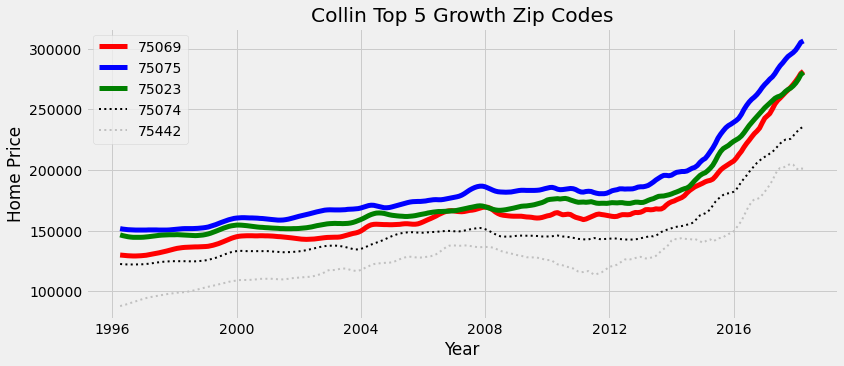

In [407]:
fig = plot_top3_5(all_perc_change_dict,Collin_dict_full,'Collin')
# fig = ax.get_figure()
ax = fig.get_axes()


In [33]:
county_name = ['Travis', 'Bexar', 'Harris', 'El_Paso', 'Collin', 'Denton']
county_dict_full = [travis_dict_full, Bexar_dict_full, Harris_dict_full, 
                           El_Paso_dict_full, Collin_dict_full, Denton_dict_full]

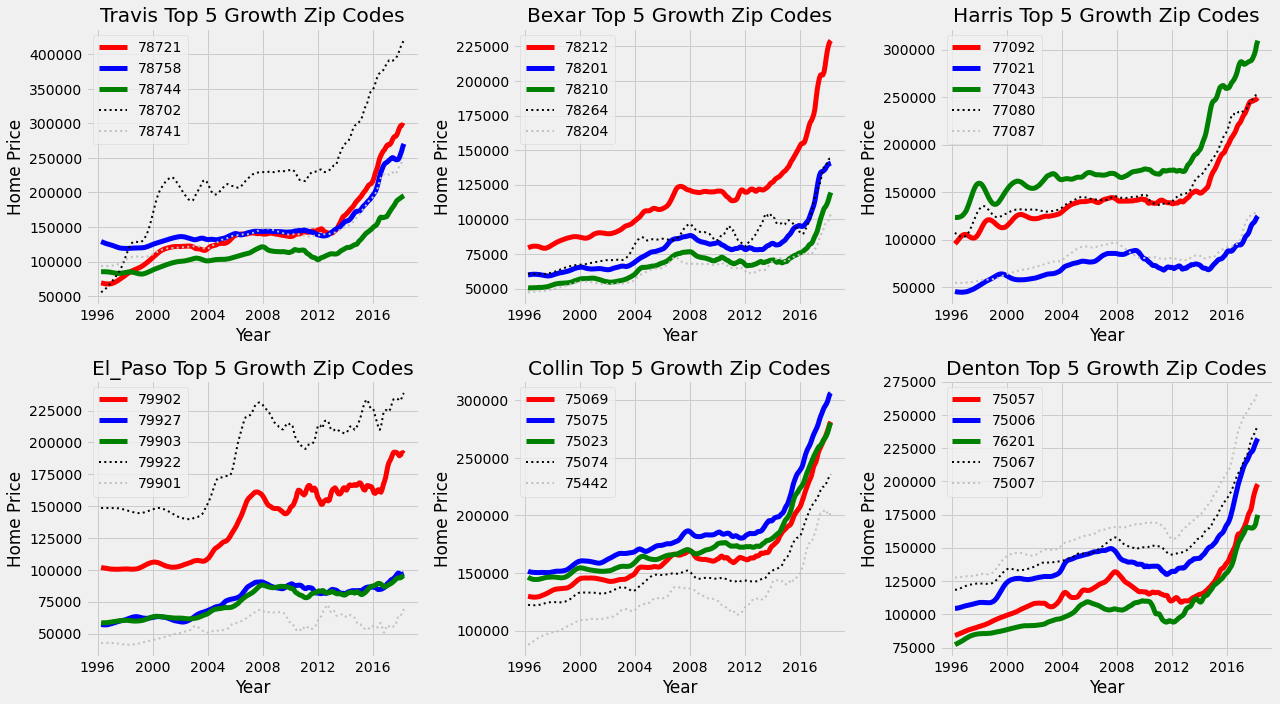

In [34]:
county_name = ['Travis', 'Bexar', 'Harris', 'El_Paso', 'Collin', 'Denton']
county_dict_full = [travis_dict_full, Bexar_dict_full, Harris_dict_full, 
                           El_Paso_dict_full, Collin_dict_full, Denton_dict_full]

with plt.style.context('fivethirtyeight'):
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18,10))
    for ax, name, dict_ in zip(axes.flatten(), county_name, county_dict_full):
        top_5=list(all_perc_change_dict[name].index)[:5]
        sns.lineplot(data=dict_[top_5[0]]['value'], color='red', label=top_5[0], lw=5, ax=ax)
        sns.lineplot(data=dict_[top_5[1]]['value'], color='blue', label=top_5[1], lw=5, ax=ax)
        sns.lineplot(data=dict_[top_5[2]]['value'], color='green', label=top_5[2], lw=5, ax=ax)
        sns.lineplot(data=dict_[top_5[3]]['value'], color='black', label=top_5[3], lw=2, ls=':', ax=ax)
        sns.lineplot(data=dict_[top_5[4]]['value'], color='silver', label=top_5[4], lw=2, ls=':', ax=ax)
        ax.set_title(f"{name} Top 5 Growth Zip Codes")
        ax.set_ylabel('Home Price')
        ax.set_xlabel('Year')
        ax.legend()
        fig.tight_layout()

In [35]:
# Create a dictionary with each region and the top 3 zips and then create list of top 3 zips

In [36]:
county_name = ['Travis', 'Bexar', 'Harris', 'El_Paso', 'Collin', 'Denton']
top_zip_per_county = {}
for county in county_name:
    top_zip_per_county[county]=list(all_perc_change_dict['Travis'].index)[:3]

In [37]:
top_zip_per_county

{'Travis': [78721, 78758, 78744],
 'Bexar': [78721, 78758, 78744],
 'Harris': [78721, 78758, 78744],
 'El_Paso': [78721, 78758, 78744],
 'Collin': [78721, 78758, 78744],
 'Denton': [78721, 78758, 78744]}

In [38]:
total_top_zips = []
for k, v in top_zip_per_county.items():
    total_top_zips.extend(v)
total_top_zips

[78721,
 78758,
 78744,
 78721,
 78758,
 78744,
 78721,
 78758,
 78744,
 78721,
 78758,
 78744,
 78721,
 78758,
 78744,
 78721,
 78758,
 78744]

Get the bars to show price change on one side and the other axis in histograms of different prices per year

Show summary statistics for the top zipcodes. what would i show given there's only one datapoint except for time per zip

In [39]:
df_travis_test = travis_dict_full[78721]['value'].resample(rule='A').mean().to_frame().copy()

In [40]:
df_travis_test['yearly_change'] = df_travis_test.pct_change(periods=1)

In [41]:
df_travis_test.tail()

,value,yearly_change
time,,
2014-12-31,178141.666667,0.171792
2015-12-31,203225.000000,0.140806
2016-12-31,243900.000000,0.200148
2017-12-31,277683.333333,0.138513
2018-12-31,296850.000000,0.069023


<ipython-input-42-af92ccbe4b68>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(range(1996,2019))


''

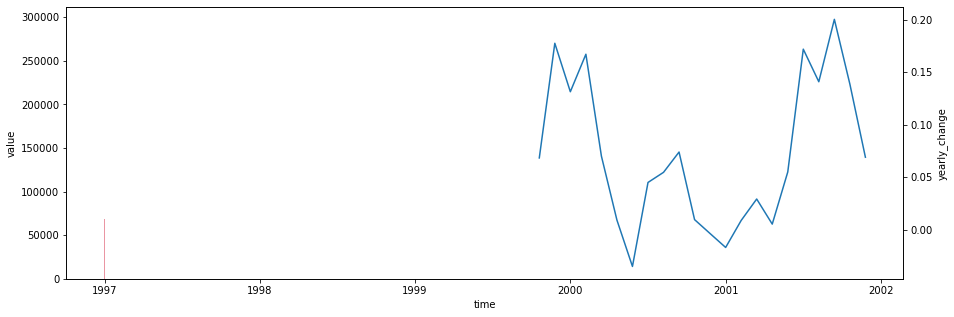

In [42]:
fig, ax = plt.subplots(figsize=(15,5))
sns.barplot(data=df_travis_test, x=df_travis_test.index, y=df_travis_test['value'], ax=ax)
ax.set_xticklabels(range(1996,2019))
ax1 = ax.twinx()
sns.lineplot(data=df_travis_test, x=df_travis_test.index, y=df_travis_test['yearly_change'], ax=ax1)
ax1.set_xticklabels(range(1996,2019))


;

In [43]:
range(5,15)

range(5, 15)

In [44]:
df_travis_test.index

DatetimeIndex(['1996-12-31', '1997-12-31', '1998-12-31', '1999-12-31',
               '2000-12-31', '2001-12-31', '2002-12-31', '2003-12-31',
               '2004-12-31', '2005-12-31', '2006-12-31', '2007-12-31',
               '2008-12-31', '2009-12-31', '2010-12-31', '2011-12-31',
               '2012-12-31', '2013-12-31', '2014-12-31', '2015-12-31',
               '2016-12-31', '2017-12-31', '2018-12-31'],
              dtype='datetime64[ns]', name='time', freq='A-DEC')

# Step 4: Reshape from Wide to Long Format

In [46]:
# font = {'family' : 'normal',
#         'weight' : 'bold',
#         'size'   : 22}

# matplotlib.rc('font', **font)

# NOTE: if you visualizations are too cluttered to read, try calling 'plt.gcf().autofmt_xdate()'!

# Step 5: ARIMA Modeling

## Travis County EDA: 78721, 78758, 78744

In [48]:
df_78721=travis_dict_full[78721].copy()

In [50]:
df_78721.drop(columns='RegionName', axis=1, inplace=True)

In [52]:
df_78721.isna().sum()

value    0
dtype: int64

In [53]:
df_78721.describe()

,value
count,265.000000
mean,143692.452830
std,51937.036652
min,67600.000000
25%,118700.000000
50%,138800.000000
75%,144600.000000
max,297800.000000


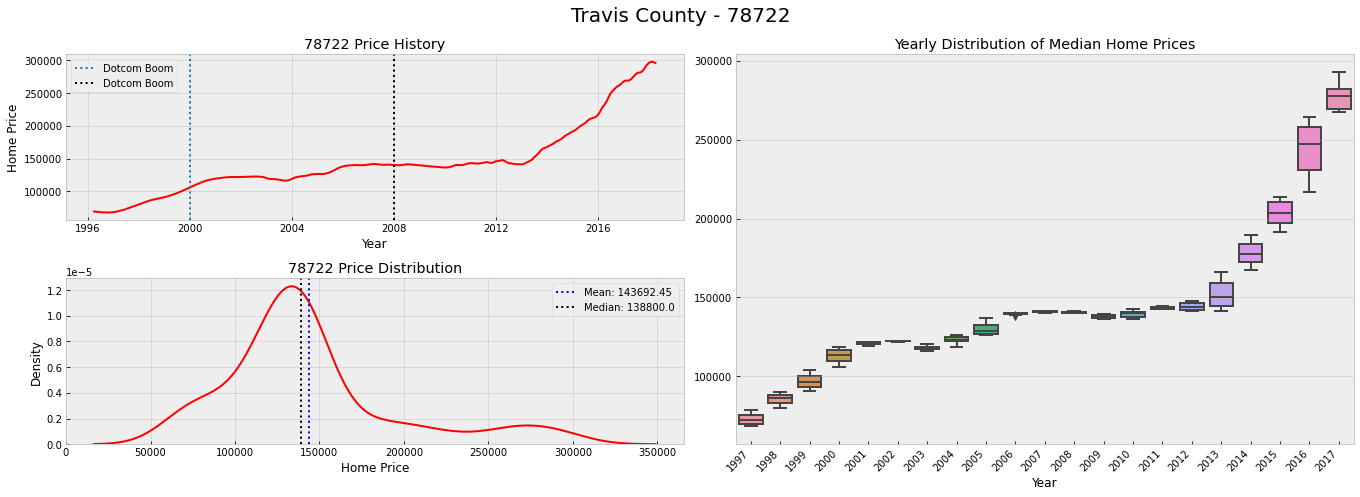

In [276]:
from matplotlib.gridspec import GridSpec
with plt.style.context('bmh'):
    
    
    fig = plt.figure(figsize=(19, 7), constrained_layout=False)
    gs = GridSpec(nrows=2, ncols=2)
    # First axes
    ax0 = fig.add_subplot(gs[0, 0])
    ax0.plot(df_78721['value'], color='r')
    ax0.set_title('78722 Price History')
    ax0.set_xlabel('Year')
    ax0.set_ylabel('Home Price')
    ax0.axvline(x='2000-01-01', label='Dotcom Boom', ls=':')
    ax0.axvline(x='2008-01-01', label='Dotcom Boom', ls=':', color='k')
    ax0.legend()
    # Second axes
    ax1 = fig.add_subplot(gs[1, 0])
    sns.kdeplot(df_78721['value'], ax=ax1, color='r')
    ax1.set_title('78722 Price Distribution')
    ax1.set_xlabel('Home Price')
    
    mean=df_78721['value'].mean()
    median=df_78721['value'].median()
    ax1.axvline(x=mean, label=f"Mean: {round(mean,2)}", ls=':', color='blue')
    ax1.axvline(x=median, label=f"Median: {round(median,2)}", ls=':', color='k')
    ax1.legend()
    # Third axes
    ax2 = fig.add_subplot(gs[:, 1])
    sns.boxplot(data=df_78721_annual, ax=ax2)
    xticklabels = (range(1997,2018))
    ax2.set_xlabel('Year')
    ax2.set_xticklabels(xticklabels, rotation = 45, ha="right")
    ax2.set_title('Yearly Distribution of Median Home Prices')
    
    fig.suptitle('Travis County - 78722', fontsize=20)
    fig.tight_layout();  

<AxesSubplot:>

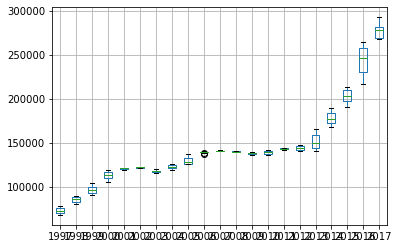

In [76]:
groups = df_78721['1997-01-01':'2017-12-12'].groupby(pd.Grouper(freq='A'))
df_78721_annual=pd.DataFrame()
for name, group in groups:
        df_78721_annual[name.year]=group.values.ravel()


<AxesSubplot:>

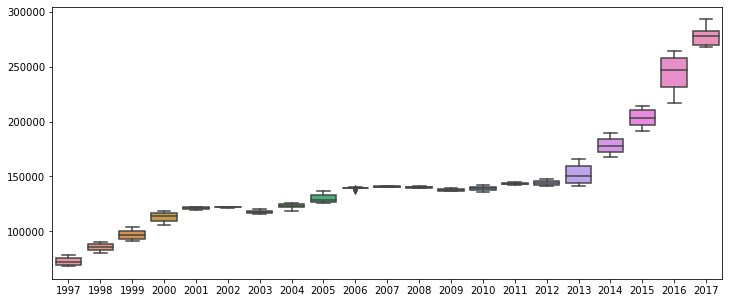

In [79]:
fig, ax = plt.subplots(figsize=(12,5))
sns.boxplot(data=df_78721_annual)

Put all EDA into one function, control for line plot, describe, boxplot, and custom time ranges

Set up Train Test Split

<AxesSubplot:xlabel='time'>

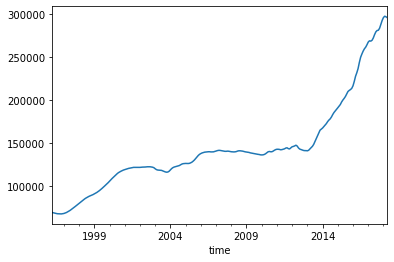

In [290]:
df_78721['value'].plot()

In [300]:
train_78721 = df_78721.iloc[:int(total_rows*0.90)]['value']
test_78721 = df_78721.iloc[int(total_rows*0.90):]['value']

In [325]:
int(total_rows*0.90)

238

<AxesSubplot:xlabel='time'>

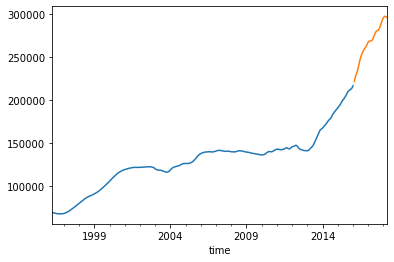

In [301]:
train_78721.plot()
test_78721.plot()

In [307]:
from statsmodels.tsa.stattools import adfuller
print('Augmented Dickey-Fuller Test on Airline Data')
dftest = adfuller(train_78721,autolag='AIC')
dftest

Augmented Dickey-Fuller Test on Airline Data


(0.6660108601285022,
 0.9891345680112835,
 9,
 228,
 {'1%': -3.4593607492757554,
  '5%': -2.8743015807562924,
  '10%': -2.5735714042782396},
 3201.360309391365)

In [378]:
train_78721=train_78721.resample('MS').asfreq()

In [528]:




model = auto_arima(train_78721,start_p=0, start_q=0, start_P=0, 
           start_Q=0,seasonal=True,m=12)
model

ARIMA(order=(2, 2, 0), scoring_args={}, seasonal_order=(1, 0, 1, 12),
      suppress_warnings=True, with_intercept=False)

In [534]:
print(model.seasonal_order)
print(model.order)

(1, 0, 1, 12)
(2, 2, 0)


Auto-Arima Loop
- set start pdq PDQ and max pdq PDQ
- try other params

In [523]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  238
Model:             SARIMAX(0, 0, [1, 2, 3, 4], 12)   Log Likelihood               -2712.797
Date:                             Mon, 14 Jun 2021   AIC                           5437.594
Time:                                     19:11:10   BIC                           5458.427
Sample:                                          0   HQIC                          5445.990
                                             - 238                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1.296e+05   2.28e+04      5.685      0.000    8.49e+04    1.74e+05
ma.S.L12       1.3290      0.456      2.915      0.004       0.435       2.223
ma.S.L24       1.1440      0.802      1.426      0.154      -0.428       2.716
ma.S.L36       0.6943      1.837      0.378      0.706      -2.907       4.296
ma.S.L48       0.2569      1.749      0.147      0.883      -3.171       3.685
sigma2       9.95e+08      0.698   1.43e+09      0.000    9.95e+08    9.95e+08
===================================================================================
Ljung-Box (L1) (Q):                 223.31   Jarque-Bera (JB):                37.95
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.78   Skew:                             0.11
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.52e+25. Standard errors may be unstable.
"""

In [542]:
# Only lbfgs would fit othersise model fit warning

model = auto_arima(train_78721,start_p=0, start_q=0, max_p=4, max_q=4, start_P=0,
start_Q=0, max_4=4, max_D=3, max_Q=4,seasonal=True, m=12)
model.summary()   


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  238
Model:             SARIMAX(2, 2, 0)x(1, 0, [1], 12)   Log Likelihood               -1739.392
Date:                              Mon, 14 Jun 2021   AIC                           3488.785
Time:                                      20:42:27   BIC                           3506.104
Sample:                                           0   HQIC                          3495.766
                                              - 238                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1550      0.019      8.283      0.000       0.118       0.192
ar.L2         -0.1922      0.015    -13.034      0.000      -0.221      -0.163
ar.S.L12       0.5516      0.334      1.651      0.099      -0.103       1.207
ma.S.L12      -0.6463      0.325     -1.987      0.047      -1.284      -0.009
sigma2      1.208e+05   7024.836     17.194      0.000    1.07e+05    1.35e+05
===================================================================================
Ljung-Box (L1) (Q):                   5.68   Jarque-Bera (JB):               166.48
Prob(Q):                              0.02   Prob(JB):                         0.00
Heteroskedasticity (H):               5.62   Skew:                            -0.43
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.02
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
model = auto_arima(train_78721,start_p=0, start_q=0, start_P=0, 
           start_Q=0,seasonal=True,m=12)

In [535]:
model.order

(2, 2, 0)

In [546]:
def find_auto_order(df_train):
    model = auto_arima(df_train,start_p=0, start_q=0, max_p=4, max_q=4, start_P=0,
    start_Q=0, max_4=4, max_D=3, max_Q=4,seasonal=True, m=12)
    summary = model.summary()
    ARMA_order = model.order
    seasonal_order = model.seasonal_order
    return summary, ARMA_order, seasonal_order

In [547]:
test_summary, test_arma, test_seasonal = find_auto_order(train_78721)

In [548]:
test_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  238
Model:             SARIMAX(2, 2, 0)x(1, 0, [1], 12)   Log Likelihood               -1739.392
Date:                              Mon, 14 Jun 2021   AIC                           3488.785
Time:                                      20:43:18   BIC                           3506.104
Sample:                                           0   HQIC                          3495.766
                                              - 238                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1550      0.019      8.283      0.000       0.118       0.192
ar.L2         -0.1922      0.015    -13.034      0.000      -0.221      -0.163
ar.S.L12       0.5516      0.334      1.651      0.099      -0.103       1.207
ma.S.L12      -0.6463      0.325     -1.987      0.047      -1.284      -0.009
sigma2      1.208e+05   7024.836     17.194      0.000    1.07e+05    1.35e+05
===================================================================================
Ljung-Box (L1) (Q):                   5.68   Jarque-Bera (JB):               166.48
Prob(Q):                              0.02   Prob(JB):                         0.00
Heteroskedasticity (H):               5.62   Skew:                            -0.43
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.02
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [549]:
test_arma

(2, 2, 0)

In [550]:
test_seasonal

(1, 0, 1, 12)

In [569]:
def SARIMAX_man_results(train_data, arma_order, seasonal_order):
    grid_results = []
    grid_tests = []
    trend = ['n','ct']
    mle_regression=[True,False]
    concentrate_scale = [True, False]
    results_dict = {}

    for t in trend:
        for mle in mle_regression:
            for scale in concentrate_scale:
                model = SARIMAX(train_data,order=arma_order, seasonal_order=seasonal_order,
                            enforce_stationarity=False, enforce_invertibility=False,
                            trend=t, mle_regression=mle, concentrate_scale=scale,freq='MS')
                results = model.fit()
                score_ = results.aic

                grid_tests.append([t, mle, scale])
                grid_results.append(score_)
        df = pd.DataFrame(grid_tests, grid_results).sort_index()
        df = df.rename(columns={0: 'Trend', 1: 'MLE_Regression', 2: 'Concentrate_Scale'})
        results_dict['grid_search'] = df
        diagnostics = results.plot_diagnostics(figsize=(8,8))
        results_dict['diag_summary'] = diagnostics
    return results_dict

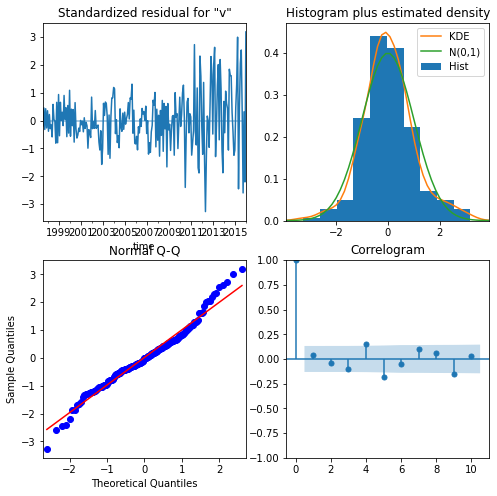

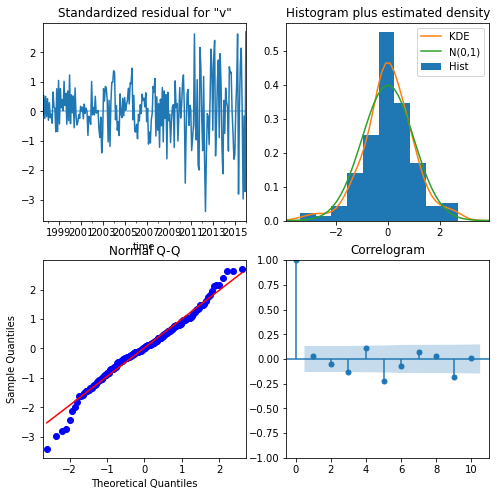

In [564]:
test = SARIMAX_man_results(train_78721, test_arma, test_seasonal)

In [565]:
test.keys()

dict_keys(['grid_search', 'diag'])

In [570]:
test['grid_search']

,Trend,MLE_Regression,Concentrate_Scale
3212.161458,ct,True,True
3212.161458,ct,False,True
3213.640520,n,True,True
3213.640520,n,False,True
3215.497884,ct,True,False
3215.497884,ct,False,False
3217.360059,n,True,False
3217.360059,n,False,False


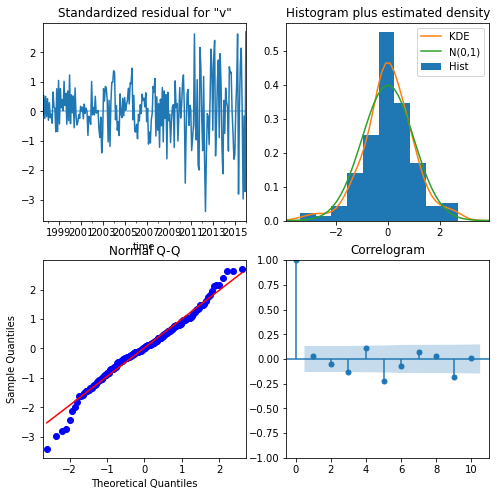

In [571]:
test['diag']

In [509]:
model = SARIMAX(train_78721,order=(2,2,0),seasonal_order=(1,0,1,12), enforce_invertibility=False, 
                enforce_stationarity=False, freq='MS')
results = model.fit()
results.aic

3217.3600592051125

Create gridsearch to find best Sarimax model

In [505]:
grid_results = []
grid_tests = []
trend = ['n','ct']
mle_regression=[True,False]
concentrate_scale = [True, False]

for t in trend:
    for mle in mle_regression:
        for scale in concentrate_scale:
            model = SARIMAX(train_78721,order=(2,2,0), seasonal_order=(1,0,1,12),
                        enforce_stationarity=False, enforce_invertibility=False,
                        trend=t, mle_regression=mle, concentrate_scale=scale,freq='MS')
            results = model.fit()
            score_ = results.aic

            grid_tests.append([t, mle, scale])
            grid_results.append(score_)
print(grid_results)
print(grid_tests)

[3213.640519924861, 3217.3600592051125, 3213.640519924861, 3217.3600592051125, 3212.1614576462553, 3215.497884471754, 3212.1614576462553, 3215.497884471754]
[['n', True, True], ['n', True, False], ['n', False, True], ['n', False, False], ['ct', True, True], ['ct', True, False], ['ct', False, True], ['ct', False, False]]


In [411]:
## Get forecast 
forecast = results.get_forecast(steps=len(test_78721),dynamic=True)

## save forecasted mean and upper/lower ci as df
forecast_df = forecast.conf_int()
forecast_df.columns = ['Lower CI','Upper CI']
forecast_df['Forecast'] = forecast.predicted_mean
forecast_df

,Lower CI,Upper CI,Forecast
2016-02-01,219511.063979,220768.310499,220139.687239
2016-03-01,220671.080471,223969.114861,222320.097666
2016-04-01,220333.955340,225787.698934,223060.827137
2016-05-01,220706.186246,228185.792913,224445.989579
2016-06-01,222068.787566,231632.186006,226850.486786
2016-07-01,222758.574338,234685.284877,228721.929608
2016-08-01,221801.029265,236386.074522,229093.551893
2016-09-01,220262.379627,237678.595077,228970.487352
2016-10-01,219946.348394,240294.021722,230120.185058
2016-11-01,220337.835755,243738.552352,232038.194053


[Text(0, 0.5, 'Crime Count')]

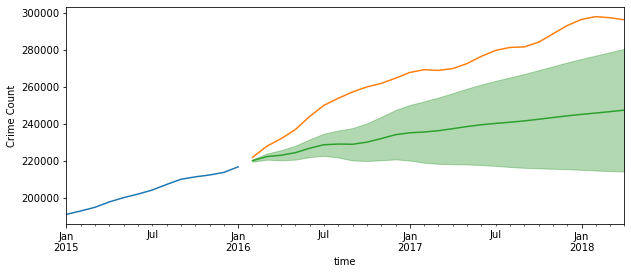

In [412]:
fig,ax = plt.subplots(figsize=(10,4))

                      
# Plotting Training and test data
train_78721['2015-01-01':].plot(label='Training Data')
test_78721['2015-01-01':].plot(label='Test Data')

## Plotting Forefcast and CI
forecast_df['Forecast'].plot(ax=ax,label='Forecast')
ax.fill_between(forecast_df.index,
                forecast_df['Lower CI'], 
                forecast_df['Upper CI'],color='g',alpha=0.3)

ax.set(ylabel='Crime Count')
# ax.legend()

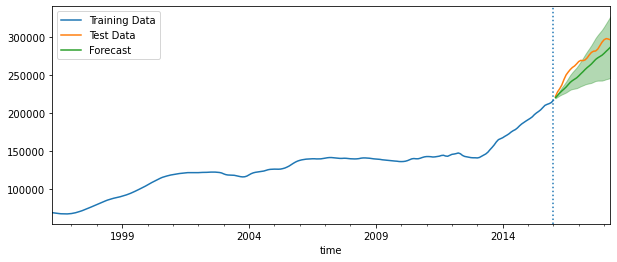

In [401]:
# Rerun on entire dataset to get further forecasts
## Get forecast 
forecast = results.get_forecast(steps=len(test_78721))

## save forecasted mean and upper/lower ci as df
forecast_df = forecast.conf_int()
forecast_df.columns = ['Lower CI','Upper CI']
forecast_df['Forecast'] = forecast.predicted_mean

## Plot
last_n_lags=52

fig,ax = plt.subplots(figsize=(10,4))

                      
# Plotting Training and test data
train_78721.plot(label='Training Data')
test_78721.plot(label='Test Data')
ax.axvline(train_78721.index[-1],ls=':')
# test.plot(label='Test Data')

## Plotting Forefcast and CI
forecast_df['Forecast'].plot(ax=ax,label='Forecast')
ax.fill_between(forecast_df.index,
                forecast_df['Lower CI'], 
                forecast_df['Upper CI'],color='g',alpha=0.3)
# ax.set_xlim(left='2018-01-01', right='2020-01-01')
ax.legend()

In [347]:
test_78721.index

DatetimeIndex(['2016-02-01', '2016-03-01', '2016-04-01', '2016-05-01',
               '2016-06-01', '2016-07-01', '2016-08-01', '2016-09-01',
               '2016-10-01', '2016-11-01', '2016-12-01', '2017-01-01',
               '2017-02-01', '2017-03-01', '2017-04-01', '2017-05-01',
               '2017-06-01', '2017-07-01', '2017-08-01', '2017-09-01',
               '2017-10-01', '2017-11-01', '2017-12-01', '2018-01-01',
               '2018-02-01', '2018-03-01', '2018-04-01'],
              dtype='datetime64[ns]', name='time', freq=None)

In [348]:
len(test_78721)

27

In [354]:
forecast_df

,Lower CI,Upper CI,Forecast
2016-02-01,219255.550239,220617.876387,219936.713313
2016-03-01,221130.051633,224366.618592,222748.335113
2016-04-01,222701.078293,228067.318187,225384.198240
2016-05-01,224258.357224,231977.410796,228117.884010
2016-06-01,225776.401885,236096.039366,230936.220625
2016-07-01,227110.721858,240272.528326,233691.625092
2016-08-01,228198.281761,244422.473123,236310.377442
2016-09-01,229163.011706,248652.640661,238907.826184
2016-10-01,230186.334285,253132.842877,241659.588581
2016-11-01,231192.805696,257778.185388,244485.495542


Trying with prediction

In [396]:
df_78721.index[238]

Timestamp('2016-02-01 00:00:00')

In [397]:
## Get prediction 
prediction = results.get_prediction(start=df_78721.index[238], end=df_78721.index[-1])

## save predictioned mean and upper/lower ci as df
prediction_df = prediction.conf_int()
prediction_df.columns = ['Lower CI','Upper CI']
prediction_df['prediction'] = prediction.predicted_mean
prediction_df

,Lower CI,Upper CI,prediction
2016-02-01,219435.447409,221068.076903,220251.762156
2016-03-01,221222.827207,225283.985520,223253.406364
2016-04-01,222992.022976,229639.422644,226315.722810
2016-05-01,224464.486504,233626.416636,229045.451570
2016-06-01,225673.988694,237337.537526,231505.763110
2016-07-01,227017.923774,241242.824006,234130.373890
2016-08-01,228845.313534,245688.308026,237266.810780
2016-09-01,230634.369545,250112.407853,240373.388699
2016-10-01,231547.507900,253648.201203,242597.854551
2016-11-01,232076.193687,256776.267331,244426.230509


Dickey Fuller Test Function

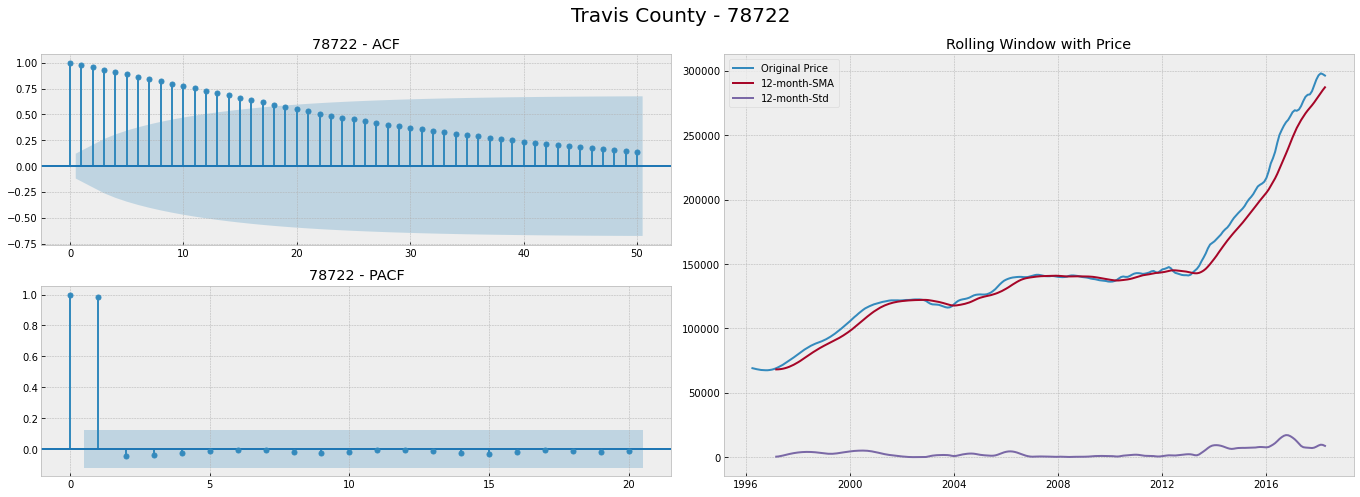

In [288]:
# Create diagnostic helper function
from matplotlib.gridspec import GridSpec
with plt.style.context('bmh'):
    
    
    fig = plt.figure(figsize=(19, 7), constrained_layout=False)
    gs = GridSpec(nrows=2, ncols=2)
    
    
    # First axes
    ax0 = fig.add_subplot(gs[0, 0])
    plot_acf(df_78721['value'],lags=lags, ax=ax0);
    ax0.set_title('78722 - ACF')
    
    # Second axes
    ax1 = fig.add_subplot(gs[1, 0])    
    plot_pacf(df_78721['value'],lags=20, ax=ax1)
    ax1.set_title('78722 - PACF')
    
    
    # Third axes
    ax2 = fig.add_subplot(gs[:, 1])    
    df_78721['12-month-SMA'] = df_78721['value'].rolling(window=12).mean()
    df_78721['12-month-Std'] = df_78721['value'].rolling(window=12).std()
    ax2.plot(df_78721['value'], label='Original Price')
    ax2.plot(df_78721['12-month-SMA'], label='12-month-SMA')
    ax2.plot(df_78721['12-month-Std'], label='12-month-Std')
    ax2.set_title('Rolling Window with Price')
    ax2.legend()
    
    fig.suptitle('Travis County - 78722', fontsize=20)
    fig.tight_layout();
    
    print('Augmented Dickey-Fuller Test on 78722')
    dfout = pd.Series(dftest[0:4],index=['ADF test statistic','p-value','# lags used','# observations'])
    for key,val in dftest[4].items():
        dfout[f'critical value ({key})']=val
    print(dfout)
    
    

In [303]:
from statsmodels.tsa.stattools import adfuller
print('Augmented Dickey-Fuller Test on Airline Data')
dftest = adfuller(df_78721['value'],autolag='AIC')
dftest

Augmented Dickey-Fuller Test on Airline Data


(-0.2712748100876962,
 0.9294752993655948,
 16,
 248,
 {'1%': -3.4569962781990573,
  '5%': -2.8732659015936024,
  '10%': -2.573018897632674},
 3725.9759876869866)

In [302]:
print('Augmented Dickey-Fuller Test on 78722')

dfout = pd.Series(dftest[0:4],index=['ADF test statistic','p-value','# lags used','# observations'])

for key,val in dftest[4].items():
    dfout[f'critical value ({key})']=val
print(dfout)

Augmented Dickey-Fuller Test on 78722
ADF test statistic       -3.038735
p-value                   0.031432
# lags used               8.000000
# observations          256.000000
critical value (1%)      -3.456155
critical value (5%)      -2.872897
critical value (10%)     -2.572822
dtype: float64


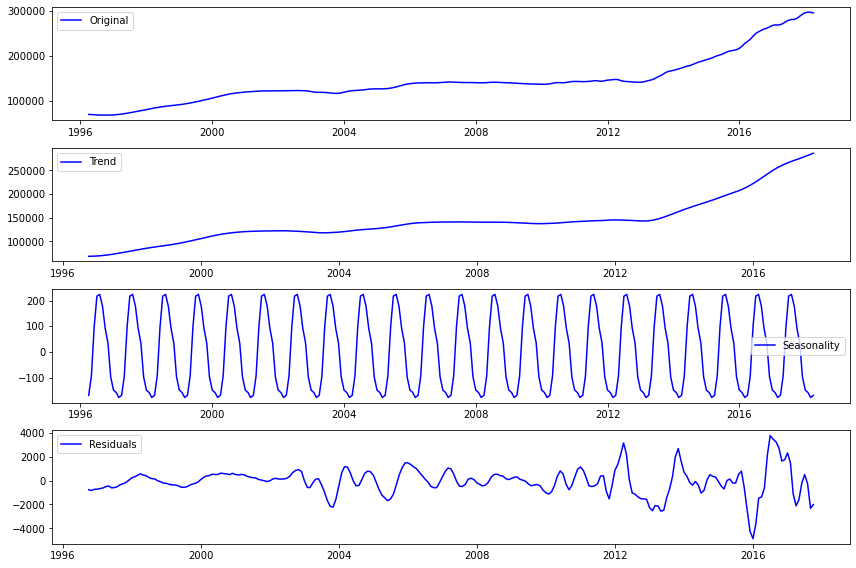

In [90]:
# Import and apply seasonal_decompose()
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df_78721['value'],model='additive')

# Gather the trend, seasonality, and residuals 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(df_78721['value'], label='Original', color='blue')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color='blue')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color='blue')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color='blue')
plt.legend(loc='best')
plt.tight_layout()

<AxesSubplot:xlabel='time'>

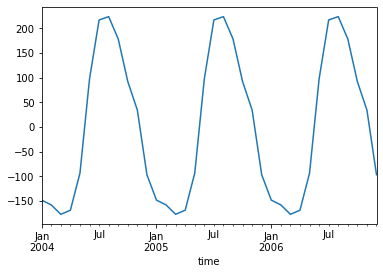

In [152]:
seasonal['2004':'2006'].plot()

In [119]:
df_78721['diff_2']=df_78721['value'].diff(2)
df_78721['diff_2'].bfill(inplace=True)
df_78721['diff_2'].isna().sum()

0

In [120]:

print('Augmented Dickey-Fuller Test on Airline Data')
dftest = adfuller(df_78721['diff_2'],autolag='AIC')
dftest

Augmented Dickey-Fuller Test on Airline Data


(-2.3920168621180236,
 0.14400227936803645,
 8,
 256,
 {'1%': -3.4561550092339512,
  '5%': -2.8728972266578676,
  '10%': -2.5728222369384763},
 3749.8667881798283)

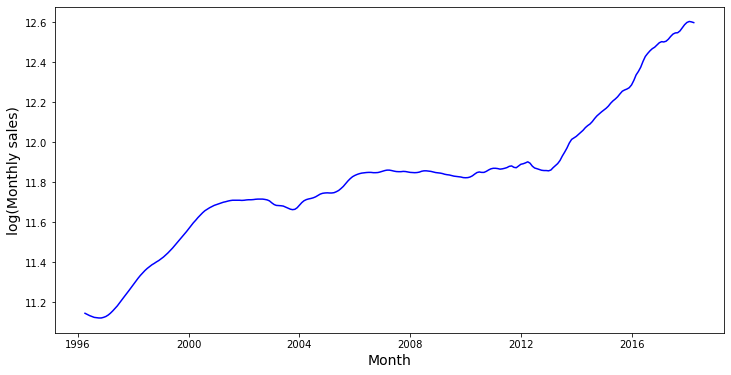

In [122]:
data = pd.Series(np.log(df_78721['value']))
fig = plt.figure(figsize=(12,6))
plt.plot(data, color='blue')
plt.xlabel('Month', fontsize=14)
plt.ylabel('log(Monthly sales)', fontsize=14)
plt.show()

In [123]:
print('Augmented Dickey-Fuller Test on Airline Data')
dftest = adfuller(data,autolag='AIC')
dftest

Augmented Dickey-Fuller Test on Airline Data


(-0.9190485720297216,
 0.7816347452337606,
 9,
 255,
 {'1%': -3.4562572510874396,
  '5%': -2.8729420379793598,
  '10%': -2.5728461399461744},
 -2263.9244476900717)

In [125]:
df_78721

,value,12-month-SMA,12-month-Std,diff_1,diff_2
time,,,,,
1996-04-01,69200.0,NaN,NaN,-800.0,-800.0
1996-05-01,68800.0,NaN,NaN,-800.0,-800.0
1996-06-01,68400.0,NaN,NaN,-800.0,-800.0
1996-07-01,68100.0,NaN,NaN,-700.0,-700.0
1996-08-01,67800.0,NaN,NaN,-600.0,-600.0
...,...,...,...,...,...
2017-12-01,293000.0,277683.333333,8330.211536,9000.0,9000.0
2018-01-01,296300.0,280066.666667,9254.319221,7800.0,7800.0
2018-02-01,297800.0,282450.000000,9864.030156,4800.0,4800.0


In [127]:
df_78721['value-sma'] = df_78721['value']- df_78721['12-month-SMA']

In [130]:
df_78721['value-sma'].bfill(inplace=True)
df_78721['value-sma'].isna().sum()

0

<AxesSubplot:xlabel='time'>

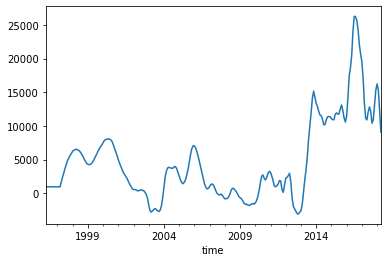

In [131]:
df_78721['value-sma']

In [132]:
print('Augmented Dickey-Fuller Test on Airline Data')
dftest = adfuller(df_78721['value-sma'],autolag='AIC')
dftest

Augmented Dickey-Fuller Test on Airline Data


(-2.2111867428138345,
 0.20221039682177527,
 16,
 248,
 {'1%': -3.4569962781990573,
  '5%': -2.8732659015936024,
  '10%': -2.573018897632674},
 3684.1625566509215)

Second order differencing was the best I could do

Plot ACF/PACF

In [134]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

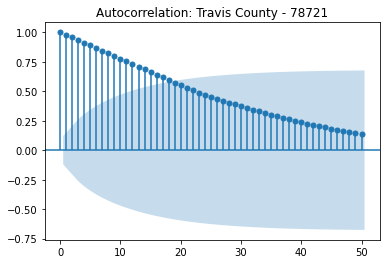

In [149]:
title = 'Autocorrelation: Travis County - 78721'
lags = 50
plot_acf(df_78721['value'],title=title,lags=lags);

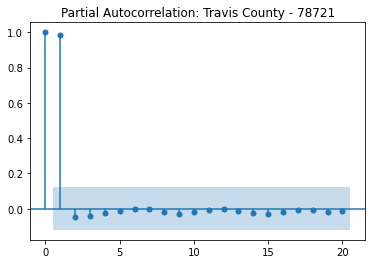

In [148]:
title='Partial Autocorrelation: Travis County - 78721'
lags=20
plot_pacf(df_78721['value'],title=title,lags=lags);

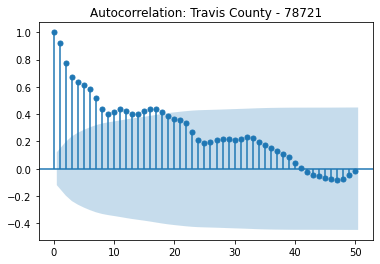

In [147]:
title = 'Autocorrelation: Travis County - 78721'
lags = 50
plot_acf(df_78721['diff_2'],title=title,lags=lags);

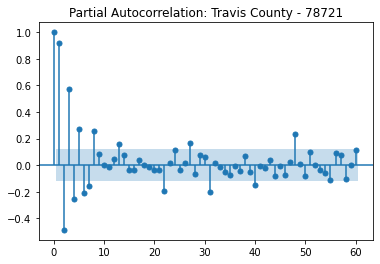

In [145]:
title='Partial Autocorrelation: Travis County - 78721'
lags=60
plot_pacf(df_78721['diff_2'],title=title,lags=lags);

Try Percent change with Dickey Fuller

In [154]:
df_78721['pct_change']=df_78721['value'].pct_change(periods=1)

In [160]:
df_78721['pct_change'].bfill(inplace=True)

In [161]:
print('Augmented Dickey-Fuller Test on Airline Data')
dftest = adfuller(df_78721['pct_change'],autolag='AIC')
dftest

Augmented Dickey-Fuller Test on Airline Data


(-3.038735355318915,
 0.031431955784841356,
 8,
 256,
 {'1%': -3.4561550092339512,
  '5%': -2.8728972266578676,
  '10%': -2.5728222369384763},
 -2262.0206972373535)

In [162]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima 

In [164]:
# For SARIMA Orders we set seasonal=True and pass in an m value
auto_arima(df_78721['value'],start_p=0, start_q=0, seasonal=True,m=12).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  265
Model:             SARIMAX(3, 2, 1)x(0, 0, [1, 2], 12)   Log Likelihood               -2042.093
Date:                                 Mon, 14 Jun 2021   AIC                           4098.187
Time:                                         10:52:23   BIC                           4123.192
Sample:                                              0   HQIC                          4108.235
                                                 - 265                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0024      0.082     12.237      0.000       0.842       1.163
ar.L2         -0.2616      0.018    -14.254      0.000      -0.298      -0.226
ar.L3          0.0839      0.028      2.960      0.003       0.028       0.139
ma.L1         -0.9056      0.085    -10.707      0.000      -1.071      -0.740
ma.S.L12      -0.0298      0.036     -0.820      0.412      -0.101       0.041
ma.S.L24      -0.0750      0.020     -3.720      0.000      -0.114      -0.035
sigma2      2.723e+05   1.52e+04     17.949      0.000    2.43e+05    3.02e+05
===================================================================================
Ljung-Box (L1) (Q):                  13.41   Jarque-Bera (JB):               107.66
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               6.43   Skew:                             0.07
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

ARIMA order of (3,2,1) and Seasonal order of (0,0,1,12)

Train test split the data

In [168]:
total_rows = len(df_78721

In [171]:
train_78721 = df_78721.iloc[:int(total_rows*0.85)]
test_78721 = df_78721.iloc[int(total_rows*0.85):]

In [175]:
test_78721.head(2)

,value,12-month-SMA,12-month-Std,diff_1,diff_2,value-sma,pct_change
time,,,,,,,
2015-01-01,191200.0,180108.333333,7377.170970,3600.0,3600.0,11091.666667,0.008971
2015-02-01,193000.0,182075.000000,7408.609856,3500.0,3500.0,10925.000000,0.009414


In [177]:
model = SARIMAX(train_78721['value'],order=(3,2,1),seasonal_order=(0,0,2,12))
results = model.fit()
results.summary()

/Users/ethankunin/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/ethankunin/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                   value   No. Observations:                  225
Model:             SARIMAX(3, 2, 1)x(0, 0, [1, 2], 12)   Log Likelihood               -1623.548
Date:                                 Mon, 14 Jun 2021   AIC                           3261.095
Time:                                         12:51:25   BIC                           3284.946
Sample:                                     04-01-1996   HQIC                          3270.723
                                          - 12-01-2014                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1099      0.658      0.167      0.867      -1.179       1.399
ar.L2         -0.2072      0.139     -1.495      0.135      -0.479       0.065
ar.L3          0.0417      0.150      0.278      0.781      -0.252       0.336
ma.L1          0.1132      0.662      0.171      0.864      -1.185       1.411
ma.S.L12      -0.1292      0.036     -3.602      0.000      -0.199      -0.059
ma.S.L24      -0.1002      0.025     -4.020      0.000      -0.149      -0.051
sigma2       9.18e+04   6185.431     14.841      0.000    7.97e+04    1.04e+05
===================================================================================
Ljung-Box (L1) (Q):                   4.38   Jarque-Bera (JB):               140.20
Prob(Q):                              0.04   Prob(JB):                         0.00
Heteroskedasticity (H):               3.88   Skew:                            -0.58
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [183]:
# Obtain predicted values
start=len(train_78721)
end=len(train_78721)+len(test_78721)-1
predictions = results.predict(start=start, end=end, dynamic=True, typ='levels').rename('SARIMA(3,2,1)(0,0,2,12) Predictions')

In [184]:
# Compare predictions to expected values
for i in range(len(predictions)):
    print(f"predicted={predictions[i]:<11.10}, expected={test_78721['value'][i]}")

predicted=191476.5247, expected=191200.0
predicted=193344.6122, expected=193000.0
predicted=195099.6144, expected=195000.0
predicted=196833.0537, expected=197900.0
predicted=198545.0287, expected=200200.0
predicted=200259.1281, expected=202100.0
predicted=201884.2748, expected=204300.0
predicted=203416.0959, expected=207300.0
predicted=204845.8329, expected=210100.0
predicted=206270.7922, expected=211400.0
predicted=207845.1246, expected=212400.0
predicted=209602.6353, expected=213800.0
predicted=211343.7835, expected=216800.0
predicted=213033.3104, expected=221900.0
predicted=214730.1361, expected=227900.0
predicted=216406.3378, expected=232000.0
predicted=218050.5631, expected=236900.0
predicted=219748.0032, expected=244000.0
predicted=221463.1103, expected=250000.0
predicted=223092.6013, expected=253800.0
predicted=224660.4155, expected=257200.0
predicted=226261.9203, expected=259900.0
predicted=227919.2885, expected=261800.0
predicted=229593.8044, expected=264600.0
predicted=231261

In [510]:
ax = test_78721['value'].plot(legend=True,figsize=(12,5))
predictions.plot(legend=True);

KeyError: 'value'

# Step 6: Interpreting Results